In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/hourly-energy-consumption/AEP_hourly.csv
/kaggle/input/hourly-energy-consumption/COMED_hourly.csv
/kaggle/input/hourly-energy-consumption/est_hourly.paruqet
/kaggle/input/hourly-energy-consumption/PJM_Load_hourly.csv
/kaggle/input/hourly-energy-consumption/pjm_hourly_est.csv
/kaggle/input/hourly-energy-consumption/PJME_hourly.csv
/kaggle/input/hourly-energy-consumption/DUQ_hourly.csv
/kaggle/input/hourly-energy-consumption/DOM_hourly.csv
/kaggle/input/hourly-energy-consumption/PJMW_hourly.csv
/kaggle/input/hourly-energy-consumption/FE_hourly.csv
/kaggle/input/hourly-energy-consumption/DAYTON_hourly.csv
/kaggle/input/hourly-energy-consumption/EKPC_hourly.csv
/kaggle/input/hourly-energy-consumption/NI_hourly.csv
/kaggle/input/hourly-energy-consumption/DEOK_hourly.csv


In [2]:
import numpy as np
from numpy import concatenate
import urllib.request as urllib
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error  
from keras.models import Sequential
from keras.layers import Dense

import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt

from sklearn.metrics import mean_squared_error,mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import LSTM


Using TensorFlow backend.


In [3]:
data = pd.read_csv('/kaggle/input/hourly-energy-consumption/PJME_hourly.csv',index_col=[0], parse_dates=[0])
data.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


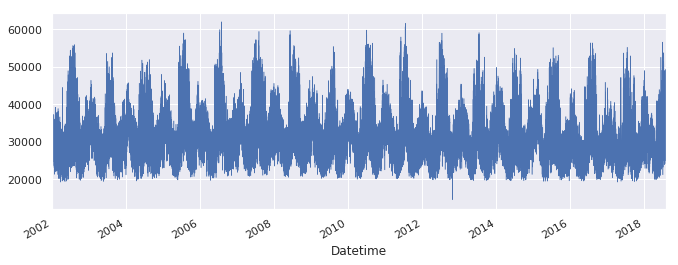

In [4]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})
data['PJME_MW'].plot(linewidth=0.5);

In [5]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(data, label='PJME_MW')

df = pd.concat([X, y], axis=1)
df.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,PJME_MW
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	#if dropnan:
		#agg.dropna(inplace=True)
	return agg
 

In [7]:
# Preprocess data
labelEncoder = LabelEncoder()
oneHotEncoder = OneHotEncoder(categorical_features=[0])
ss = StandardScaler()

values = df.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,8] = encoder.fit_transform(values[:,8])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15,16]], axis=1, inplace=True)
print(reframed.shape)
print(reframed.head())

(145366, 10)
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
0        NaN        NaN        NaN        NaN        NaN        NaN   
1   0.043478   0.166667        1.0        1.0        0.0    0.99726   
2   0.086957   0.166667        1.0        1.0        0.0    0.99726   
3   0.130435   0.166667        1.0        1.0        0.0    0.99726   
4   0.173913   0.166667        1.0        1.0        0.0    0.99726   

   var7(t-1)  var8(t-1)  var9(t-1)   var9(t)  
0        NaN        NaN        NaN  0.251849  
1        1.0        0.0   0.251849  0.223386  
2        1.0        0.0   0.223386  0.211314  
3        1.0        0.0   0.211314  0.207500  
4        1.0        0.0   0.207500  0.217339  


In [8]:
# split into train and test sets
reframed['date_time'] = df.index.values
split_date = '01-Jan-2015'

train = reframed.loc[reframed['date_time']<=split_date].drop(['date_time'],axis=1).dropna().values
test = reframed.loc[reframed['date_time']>split_date].drop(['date_time'],axis=1).dropna().values

# split into input and output
X_train, y_train = train[:, 0:-1], train[:, -1]
X_test, y_test = test[:, 0:-1], test[:, -1]

In [9]:
# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(113926, 1, 9) (113926,) (31439, 1, 9) (31439,)


In [10]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
##model.add(Dense(1,kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(X_train, y_train, epochs=20, batch_size=70, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 113926 samples, validate on 31439 samples
Epoch 1/20
 - 7s - loss: 0.0512 - val_loss: 0.0441
Epoch 2/20
 - 6s - loss: 0.0283 - val_loss: 0.0240
Epoch 3/20
 - 6s - loss: 0.0248 - val_loss: 0.0233
Epoch 4/20
 - 6s - loss: 0.0231 - val_loss: 0.0223
Epoch 5/20
 - 6s - loss: 0.0220 - val_loss: 0.0210
Epoch 6/20
 - 6s - loss: 0.0214 - val_loss: 0.0207
Epoch 7/20
 - 6s - loss: 0.0208 - val_loss: 0.0220
Epoch 8/20
 - 6s - loss: 0.0206 - val_loss: 0.0212
Epoch 9/20
 - 6s - loss: 0.0203 - val_loss: 0.0214
Epoch 10/20
 - 6s - loss: 0.0200 - val_loss: 0.0224
Epoch 11/20
 - 6s - loss: 0.0199 - val_loss: 0.0221
Epoch 12/20
 - 6s - loss: 0.0198 - val_loss: 0.0230
Epoch 13/20
 - 6s - loss: 0.0198 - val_loss: 0.0206
Epoch 14/20
 - 6s - loss: 0.0196 - val_loss: 0.0222
Epoch 15/20
 - 6s - loss: 0.0195 - val_loss: 0.0227
Epoch 16/20
 - 6s - loss: 0.0193 - val_loss: 0.0236
Epoch 17/20
 - 6s - loss: 0.0194 - val_loss: 0.0221
Epoch 18/20
 - 6s - loss: 0.0193 - val_loss: 0.0208
Epoch 19/20
 - 6s - lo

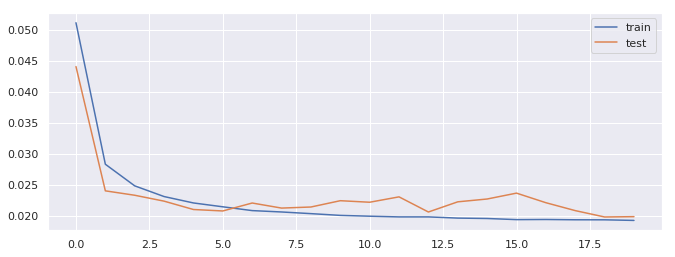

In [11]:
from matplotlib import pyplot
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [12]:
# make a prediction
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))

In [13]:
# invert scaling for forecast
inv_yhat = concatenate((X_test[:,:-1],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((X_test[:,:-1],y_test), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


In [14]:
# calculate RMSE
MSE=mean_squared_error(inv_y,inv_yhat)
MAE=mean_absolute_error(inv_y,inv_yhat)
RMSE = sqrt(mean_squared_error(inv_y, inv_yhat))
print('MSE: %.3f' % MSE + '   MAE: %.3f' % MAE + '   RMSE: %.3f' % RMSE)

MSE: 1531186.875   MAE: 940.520   RMSE: 1237.411


In [15]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(inv_y,inv_yhat))

3.148428350687027


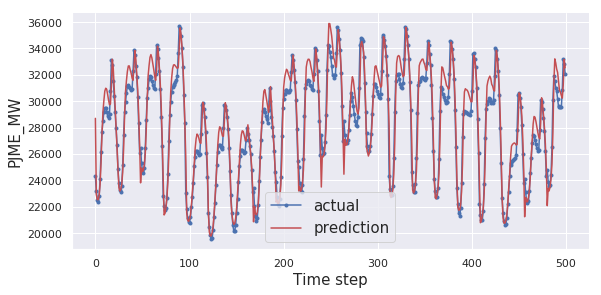

In [16]:
aa=[x for x in range(500)]
plt.figure(figsize=(8,4))
plt.plot(aa, inv_y[:500], marker='.', label="actual")
plt.plot(aa, inv_yhat[:500], 'r', label="prediction")

plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('PJME_MW', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();